In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

In [17]:
# Config
VIDEO_PATH = r'D:\Python things\middle-ml-cv-roadmap\data\raw\video_2025-12-19_08-43-16.mp4'   # <-- change this
OUT_VIDEO_PATH = "motion_annotated.mp4"

# Performance knobs
RESIZE_WIDTH = 640          # smaller => faster
PROCESS_EVERY_N = 1         # 2 => process every 2nd frame
MAX_FRAMES = None           # set e.g. 600 for quick tests

# Motion estimation knobs
MIN_FLOW_MAG = 0.2          # ignore tiny jitter
MAX_FLOW_MAG = 50.0         # ignore extreme outliers
SMOOTH_WINDOW = 10          # rolling smoothing

# Visualization knobs
ARROW_STEP = 16             # denser arrows => slower
ARROW_SCALE = 1.0           # arrow length scaling

# Output
WRITE_VIDEO = True

SHOW_LIVE_WINDOW = False    # if True, uses cv2.imshow (works best in local Jupyter)

#### Helper functions

In [4]:
def resize_keep_aspect(frame_bgr, width):
    h, w = frame_bgr.shape[:2]
    if w == width:
        return frame_bgr
    scale = width / float(w)
    new_size = (width, int(h * scale))
    return cv.resize(frame_bgr, new_size, interpolation=cv.INTER_AREA)

In [13]:
'''
Dense flow -> HSV color wheel visualization (BGR image).
'''
def flow_to_hsv_bgr(flow):    
    fx, fy = flow[..., 0], flow[..., 1]
    mag, ang = cv.cartToPolar(fx, fy, angleInDegrees=True)
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    hsv[..., 0] = (ang / 2).astype(np.uint8)                 # Hue: angle
    hsv[..., 1] = 255                                        # Saturation
    hsv[..., 2] = np.clip(mag * 8, 0, 255).astype(np.uint8)  # Value: magnitude (scaled)
    bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    return bgr

In [12]:
'''
Draw arrow grid on a copy of the frame.
'''
def draw_flow_arrows(frame_bgr, flow, step=16, scale=1.0):
    out = frame_bgr.copy()
    h, w = flow.shape[:2]
    for y in range(step//2, h, step):
        for x in range(step//2, w, step):
            fx, fy = flow[y, x]
            x2 = int(x + scale * fx)
            y2 = int(y + scale * fy)
            cv.arrowedLine(out, (x, y), (x2, y2), (0, 255, 0), 1, tipLength=0.3)
    return out

In [11]:
'''
Estimate dominant motion vector from dense flow using a robust median.
Returns (dx, dy, used_ratio).
'''
def robust_global_flow(flow, min_mag=0.2, max_mag=50.0):
    fx = flow[..., 0].reshape(-1)
    fy = flow[..., 1].reshape(-1)
    mag = np.sqrt(fx*fx + fy*fy)

    mask = (mag >= min_mag) & (mag <= max_mag) & np.isfinite(mag)
    if mask.sum() < 100:
        return 0.0, 0.0, mask.mean()

    dx = float(np.median(fx[mask]))
    dy = float(np.median(fy[mask]))
    return dx, dy, float(mask.mean())

In [10]:
'''
Labels based on *optical flow direction*:
  dx > 0 => features move right (optical flow left->right)
  dx < 0 => features move left  (optical flow right->left)
For camera translation, camera often moves opposite of average flow.
'''
def label_left_right(dx, dy, px_per_sec, thr_px_per_sec=30.0):   
    if px_per_sec < thr_px_per_sec:
        return "stable / too slow"

    if abs(dx) >= abs(dy):
        return "optical flow: left → right" if dx > 0 else "optical flow: right → left"
    else:
        return "dominant vertical motion"

In [14]:
'''
Sparse LK tracking helper (corner tracks + trails)
'''
def init_features(gray):
    pts = cv.goodFeaturesToTrack(
        gray, maxCorners=400, qualityLevel=0.01, minDistance=8, blockSize=7)
    return pts

lk_params = dict(
    winSize=(21, 21),
    maxLevel=3,
    criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 30, 0.01))

#### Main loop: dense flow + LK tracks + motion estimate + annotate video

In [19]:
cap = cv.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Cannot open video: {VIDEO_PATH}")

fps = cap.get(cv.CAP_PROP_FPS) or 30.0
ok, frame0 = cap.read()
if not ok:
    raise RuntimeError("Cannot read first frame.")

frame0 = resize_keep_aspect(frame0, RESIZE_WIDTH)
prev_gray = cv.cvtColor(frame0, cv.COLOR_BGR2GRAY)

# Init LK
p0 = init_features(prev_gray)
trail = np.zeros_like(frame0)

# Smoothing buffers
dx_hist = deque(maxlen=SMOOTH_WINDOW)
dy_hist = deque(maxlen=SMOOTH_WINDOW)

# Video writer
writer = None
if WRITE_VIDEO:
    fourcc = cv.VideoWriter_fourcc(*"mp4v")
    h, w = frame0.shape[:2]
    writer = cv.VideoWriter(OUT_VIDEO_PATH, fourcc, fps, (w, h))

frame_idx = 0
processed = 0

while True:
    ok, frame = cap.read()
    if not ok:
        break

    frame_idx += 1
    if frame_idx % PROCESS_EVERY_N != 0:
        continue

    frame = resize_keep_aspect(frame, RESIZE_WIDTH)
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # --- Dense optical flow (Farneback) ---
    flow = cv.calcOpticalFlowFarneback(
        prev_gray, gray, None,
        pyr_scale=0.5, levels=3, winsize=15,
        iterations=3, poly_n=5, poly_sigma=1.2, flags=0)

    dx, dy, used_ratio = robust_global_flow(flow, MIN_FLOW_MAG, MAX_FLOW_MAG)
    dx_hist.append(dx)
    dy_hist.append(dy)

    dx_s = float(np.median(dx_hist))
    dy_s = float(np.median(dy_hist))

    speed_px_per_frame = (dx_s*dx_s + dy_s*dy_s) ** 0.5
    speed_px_per_sec = speed_px_per_frame * fps

    label = label_left_right(dx_s, dy_s, speed_px_per_sec)

    # --- HSV visualization (dense) ---
    hsv_bgr = flow_to_hsv_bgr(flow)

    # --- Arrow grid visualization ---
    arrows = draw_flow_arrows(frame, flow, step=ARROW_STEP, scale=ARROW_SCALE)

    # --- Sparse LK tracking (points + trails) ---
    lk_vis = frame.copy()
    if p0 is None or len(p0) < 50:
        p0 = init_features(prev_gray)
        trail[:] = 0

    if p0 is not None:
        p1, st, err = cv.calcOpticalFlowPyrLK(prev_gray, gray, p0, None, **lk_params)
        if p1 is not None and st is not None:
            good_new = p1[st.flatten() == 1]
            good_old = p0[st.flatten() == 1]

            # draw trails
            for (new, old) in zip(good_new, good_old):
                a, b = new.ravel().astype(int)
                c, d = old.ravel().astype(int)
                cv.line(trail, (a, b), (c, d), (0, 0, 255), 2)
                cv.circle(lk_vis, (a, b), 2, (255, 0, 0), -1)

            lk_vis = cv.add(lk_vis, trail)
            p0 = good_new.reshape(-1, 1, 2)
        else:
            p0 = init_features(gray)
            trail[:] = 0

    # --- Compose a single annotated view (choose one main view) ---
    # Here: arrows as main view; you can switch to hsv_bgr or lk_vis.
    out = arrows

    # overlay text
    cv.putText(out, f"{label}", (10, 30), cv.FONT_HERSHEY_SIMPLEX, 0.8, (20, 20, 20), 3, cv.LINE_AA)
    cv.putText(out, f"{label}", (10, 30), cv.FONT_HERSHEY_SIMPLEX, 0.8, (240, 240, 240), 1, cv.LINE_AA)

    cv.putText(out, f"dx={dx_s:+.2f}px  dy={dy_s:+.2f}px  speed={speed_px_per_sec:.1f}px/s  used={used_ratio:.2f}",
                (10, 60), cv.FONT_HERSHEY_SIMPLEX, 0.55, (240, 240, 240), 1, cv.LINE_AA)

    # Optional: explain camera direction (often opposite of average flow for pure translation)
    cam_hint = "inferred camera: right" if dx_s < 0 else "inferred camera: left"
    cv.putText(out, cam_hint, (10, 85), cv.FONT_HERSHEY_SIMPLEX, 0.55, (240, 240, 240), 1, cv.LINE_AA)

    if writer is not None:
        writer.write(out)

    if SHOW_LIVE_WINDOW:
        cv.imshow("Optical Motion (annotated)", out)
        if cv.waitKey(1) & 0xFF == ord('q'):
            break

    prev_gray = gray
    processed += 1
    if MAX_FRAMES is not None and processed >= MAX_FRAMES:
        break

cap.release()
if writer is not None:
    writer.release()
if SHOW_LIVE_WINDOW:
    cv.destroyAllWindows()

print("Done.")
if WRITE_VIDEO:
    print("Saved:", os.path.abspath(OUT_VIDEO_PATH))

Done.
Saved: D:\Python things\middle-ml-cv-roadmap\src\weekly_projects\week_2\motion_annotated.mp4


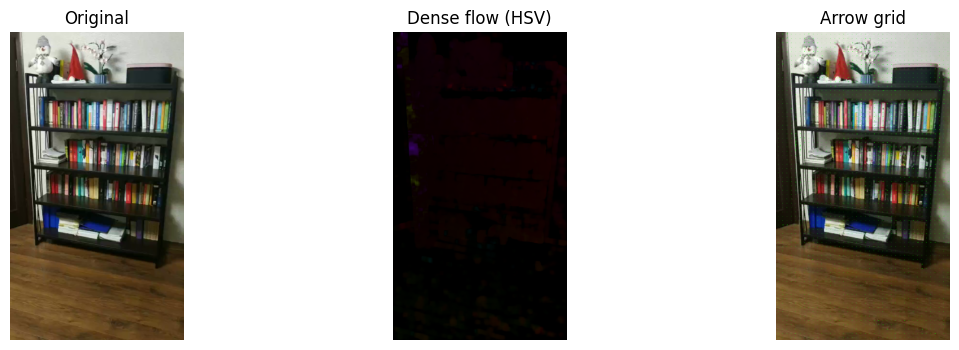

In [21]:
'''
Visualization of the three “views” for a single frame pair.
'''
cap = cv.VideoCapture(VIDEO_PATH)
ok, f0 = cap.read()
ok2, f1 = cap.read()
cap.release()

f0 = resize_keep_aspect(f0, RESIZE_WIDTH)
f1 = resize_keep_aspect(f1, RESIZE_WIDTH)
g0 = cv.cvtColor(f0, cv.COLOR_BGR2GRAY)
g1 = cv.cvtColor(f1, cv.COLOR_BGR2GRAY)

flow = cv.calcOpticalFlowFarneback(g0, g1, None, 0.5, 3, 15, 3, 5, 1.2, 0)
hsv = flow_to_hsv_bgr(flow)
arr = draw_flow_arrows(f0, flow, step=ARROW_STEP, scale=ARROW_SCALE)

# show (matplotlib expects RGB)
fig = plt.figure(figsize=(14, 4))
plt.subplot(1,3,1); plt.title("Original"); plt.imshow(cv.cvtColor(f0, cv.COLOR_BGR2RGB)); plt.axis("off")
plt.subplot(1,3,2); plt.title("Dense flow (HSV)"); plt.imshow(cv.cvtColor(hsv, cv.COLOR_BGR2RGB)); plt.axis("off")
plt.subplot(1,3,3); plt.title("Arrow grid"); plt.imshow(cv.cvtColor(arr, cv.COLOR_BGR2RGB)); plt.axis("off")
plt.show()